<a href="https://colab.research.google.com/github/folga67/data_mining/blob/master/OFedorova_hw_les3_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Урок3. Связь бизнес-показателей и DS-метрик

План занятия:
0. Ликбез: train/test/val и crossvalidation
1. переход от вероятностей к меткам в задаче бинарной классификации
2. какие бывают DS-метрики, их интерпретация
3. пример из практики
4. бизнес-метрики
5. взаимосвязь DS и бизнес метрик
6. case1 - фильтрация токсичных комментариев
7. case2 - определение ССЗ 

## Функции стоимости

Аппроксимация функции стоимости L(y!=y_true) в непрерывной форме для формирования оценки параметров w. 

In [ ]:
import seaborn

# необходимые пакеты
import matplotlib.pyplot as plt
import numpy as np

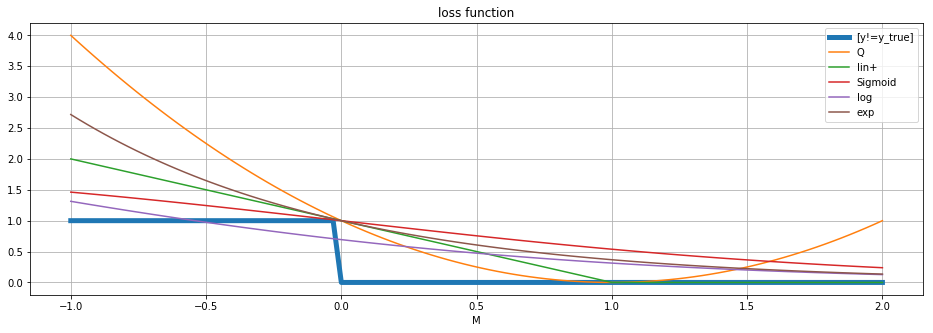

In [ ]:

M= np.linspace(-1,2,100)

P=(M<0).astype(int)
Q=(1-M)**2
Li=(1-M)
Li[np.where(Li<0)[0]]=0

S=2*(1+np.exp(M)) ** (-1)

Lo = np.log(1+np.exp(-M))
E= np.exp(-M)
plt.figure(figsize=(16,5))
plt.plot(M,P, label='[y!=y_true]',linewidth=5)
plt.plot(M,Q, label='Q')
plt.plot(M,Li, label='lin+')
plt.plot(M,S, label='Sigmoid')
plt.plot(M,Lo, label='log')
plt.plot(M,E, label='exp')
plt.title('loss function')
plt.xlabel('M')
plt.grid()
plt.legend()
plt.show()

<b>Вопрос: в чем проблема такой метрики?</b>

<b>В каком случае она может быть использована?</b>

Т.е это просто доля (процент) объектов, на которых алгоритм выдал правильные ответы. Недостаток такого функционала понятен: он плохо справляется в случае дисбаланса классов, когда представителей одного из классов существенно больше, чем второго. В этом случае, с точки зрения точности, выгодно почти всегда выдавать метку самого популярного класса. Это может не согласовываться с логикой использования решения задачи. Например, в задаче детектирования редкого заболевания алгоритм, который всех относит к классу «здоровые», бесполезен.

Такая метрика нам не подходит (если выборка сбалансирована, то может и подойти), давайте двигаться далее

Рассмотрим такую штуку, как confusion_matrix

![ab_split](confusion_matrix.png "confusion_matrix")

### Кейс 2 - определение ССЗ

ссылка на соревнование - https://mlbootcamp.ru/ru/round/12/sandbox/

В рамках конкурса вам нужно предсказать наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра. Датасет сформирован из 100.000 реальных клинических анализов, и в нём используются признаки, которые можно разбить на 3 группы:

 

Объективные признаки:

 - Возраст
 - Рост
 - Вес
 - Пол
 

Результаты измерения:

 - Артериальное давление верхнее и нижнее
 - Холестерин
 - Глюкоза
 

Субъективные признаки:

 - Курение
 - Употребление Алкоголя
 - Физическая активность
 

Возраст дан в днях. Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.

Таргет - наличие сердечно-сосудистых заболеваний (ССЗ)

In [2]:
!pip install xgboost

In [3]:
!pip install catboost

     |████████████████████████████████| 67.3MB 63kB/s 


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix, log_loss
from scipy.sparse import hstack
from scipy import stats
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import itertools

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML_lesson3/train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [7]:
df.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


Разделим наши данные на тренировочную и тестовую выборки

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [9]:
df.columns.tolist()

['id',
 'age',
 'gender',
 'height',
 'weight',
 'ap_hi',
 'ap_lo',
 'cholesterol',
 'gluc',
 'smoke',
 'alco',
 'active',
 'cardio']

In [10]:
features = ['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
target = ['cardio']

In [11]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], random_state=0)
y_train.value_counts(normalize = True), y_test.value_counts(normalize = True)

(cardio
 1         0.500933
 0         0.499067
 dtype: float64, cardio
 0         0.504
 1         0.496
 dtype: float64)

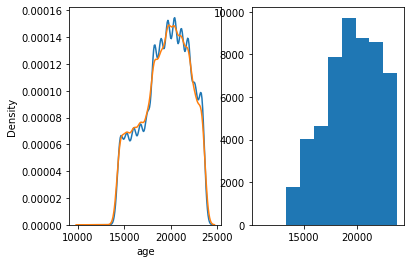

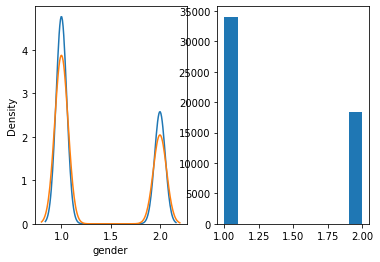

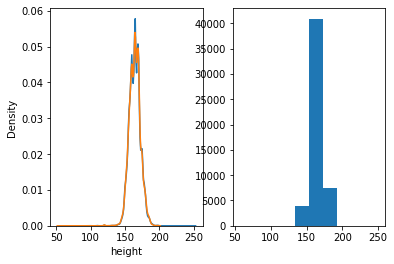

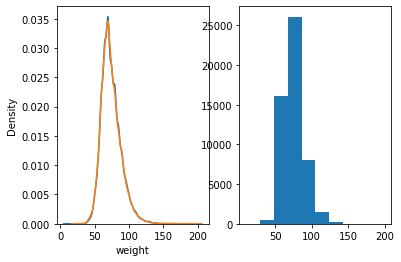

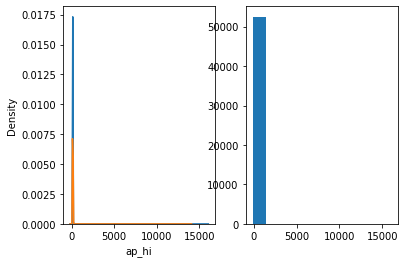

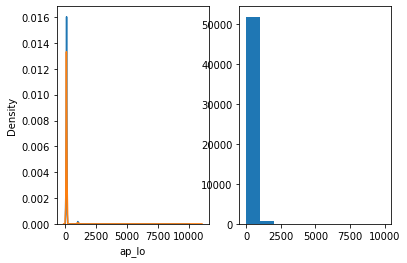

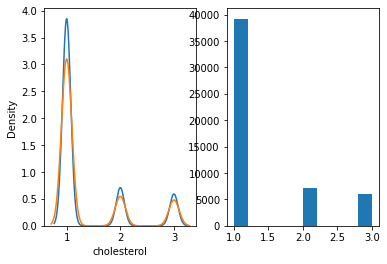

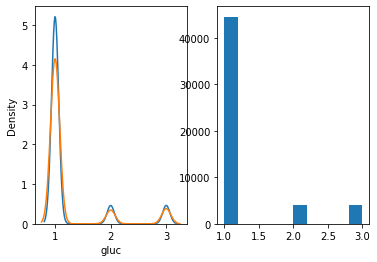

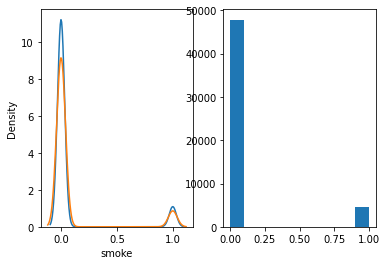

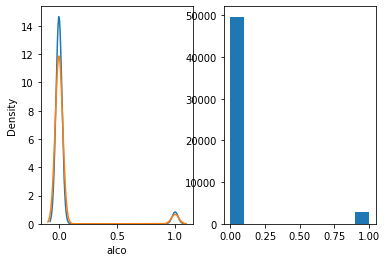

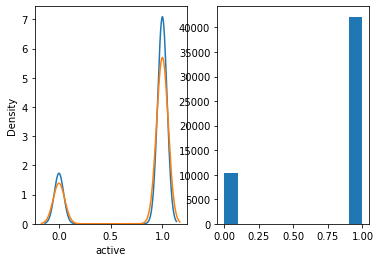

In [12]:
for name in features:
  ##plt.figure (figsize = (5,5))
  ##plt.rcParams["axes.labelsize"] = 10
  plt.subplot(1,2,1)
  sns.kdeplot(X_train[name])
  sns.kdeplot(X_test[name])
  plt.subplot(1,2,2)
  plt.hist(X_train[name])
  plt.tick_params(axis='both', which='major', labelsize=10)
  plt.show()

In [13]:
df.corr()
##самые высокие коэффициенты корреляции c признакoм cardio у признаков age, weight, cholesterol

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,1.000000,0.003457,0.003502,-0.003038,-0.001830,0.003356,-0.002529,0.006106,0.002467,-0.003699,0.001210,0.003755,0.003799
age,0.003457,1.000000,-0.022811,-0.081515,0.053684,0.020764,0.017647,0.154424,0.098703,-0.047633,-0.029723,-0.009927,0.238159
gender,0.003502,-0.022811,1.000000,0.499033,0.155406,0.006005,0.015254,-0.035821,-0.020491,0.338135,0.170966,0.005866,0.008109
height,-0.003038,-0.081515,0.499033,1.000000,0.290968,0.005488,0.006150,-0.050226,-0.018595,0.187989,0.094419,-0.006570,-0.010821
weight,-0.001830,0.053684,0.155406,0.290968,1.000000,0.030702,0.043710,0.141768,0.106857,0.067780,0.067113,-0.016867,0.181660
ap_hi,0.003356,0.020764,0.006005,0.005488,0.030702,1.000000,0.016086,0.023778,0.011841,-0.000922,0.001408,-0.000033,0.054475
ap_lo,-0.002529,0.017647,0.015254,0.006150,0.043710,0.016086,1.000000,0.024019,0.010806,0.005186,0.010601,0.004780,0.065719
cholesterol,0.006106,0.154424,-0.035821,-0.050226,0.141768,0.023778,0.024019,1.000000,0.451578,0.010354,0.035760,0.009911,0.221147
gluc,0.002467,0.098703,-0.020491,-0.018595,0.106857,0.011841,0.010806,0.451578,1.000000,-0.004756,0.011246,-0.006770,0.089307
smoke,-0.003699,-0.047633,0.338135,0.187989,0.067780,-0.000922,0.005186,0.010354,-0.004756,1.000000,0.340094,0.025858,-0.015486


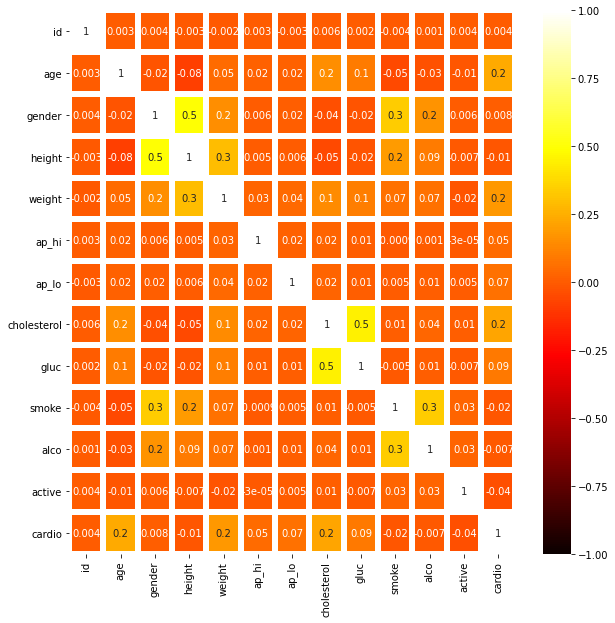

In [14]:
plt.figure(figsize = (10, 10))
sns.heatmap(df.corr(), annot = True, fmt = '0.1g', vmin =-1, vmax = 1, center = 0, cmap = 'hot', linewidths=5)
plt.tick_params(axis='both', which='major', labelsize=10)

In [15]:
##Без обработки в лоб
clf = CatBoostClassifier(random_state = 42, iterations= 40)

In [16]:
model = clf.fit(X_train, y_train.iloc[:,-1:].values.ravel())
y_score = model.predict_proba(X_test)[:, 1]

Learning rate set to 0.5
0:	learn: 0.5980762	total: 59.3ms	remaining: 2.31s
1:	learn: 0.5665638	total: 70.5ms	remaining: 1.34s
2:	learn: 0.5536993	total: 80.6ms	remaining: 994ms
3:	learn: 0.5469300	total: 91ms	remaining: 819ms
4:	learn: 0.5430832	total: 101ms	remaining: 707ms
5:	learn: 0.5413395	total: 111ms	remaining: 628ms
6:	learn: 0.5395938	total: 121ms	remaining: 570ms
7:	learn: 0.5385895	total: 132ms	remaining: 526ms
8:	learn: 0.5382552	total: 141ms	remaining: 487ms
9:	learn: 0.5379677	total: 151ms	remaining: 454ms
10:	learn: 0.5374613	total: 161ms	remaining: 426ms
11:	learn: 0.5370856	total: 171ms	remaining: 400ms
12:	learn: 0.5366636	total: 182ms	remaining: 377ms
13:	learn: 0.5364334	total: 191ms	remaining: 355ms
14:	learn: 0.5360040	total: 205ms	remaining: 342ms
15:	learn: 0.5357596	total: 215ms	remaining: 323ms
16:	learn: 0.5353386	total: 225ms	remaining: 305ms
17:	learn: 0.5350577	total: 235ms	remaining: 287ms
18:	learn: 0.5347295	total: 245ms	remaining: 271ms
19:	learn: 0.5

In [17]:
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix

b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.353824, F-Score=0.739, Precision=0.669, Recall=0.824


In [18]:
from sklearn.metrics import roc_auc_score, log_loss

#Ваш код здесь
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=model.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=model.predict_proba(X_test)[:,1])))

roc auc score: 0.802805482408017
log loss score: 0.5394315161873107


Age

In [19]:
##переведем возраст в года (разделим на 365), так удобнее ориентироваться в данных на графиках

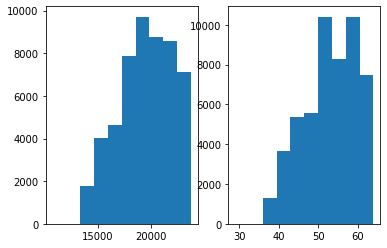

In [20]:
d = np.floor_divide( X_train['age'], 365)

plt.subplot(1,2,1)
plt.hist(X_train['age'])
plt.tick_params(axis='both', which='major', labelsize=10)
plt.subplot(1,2,2)
plt.hist(d)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()

In [22]:
## добавим признак возраст в годах 'age_year'
X_train['age_year'] = d

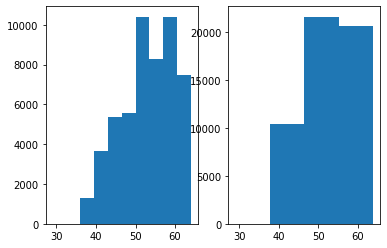

In [23]:
d1= pd.qcut(X_train['age_year'], 4, labels=False)
plt.subplot(1,2,1)
plt.hist(X_train['age_year'])
plt.tick_params(axis='both', which='major', labelsize=10)
plt.subplot(1,2,2)
plt.hist(d,bins=4)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()

In [24]:
## Добавим группировку для возраста
X_train['age_year_bins'] = d1
X_train.loc[X_train['age_year_bins'] == 2]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,age_year,age_year_bins
63679,19822,1,174,72.0,120,80,1,1,0,0,0,54,2
3947,20619,1,159,67.0,150,100,2,2,0,0,0,56,2
39150,20337,1,159,90.0,145,90,3,3,0,0,1,55,2
4706,21118,2,165,69.0,150,90,2,1,0,0,1,57,2
63359,21203,2,174,85.0,170,100,1,1,0,0,1,58,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20006,19713,1,165,90.0,120,80,1,1,0,0,0,54,2
58146,19815,1,160,71.0,125,80,2,1,0,0,1,54,2
24675,19713,2,170,85.0,130,90,1,1,1,0,0,54,2
32230,21239,1,158,48.0,150,100,1,1,0,0,1,58,2


In [25]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution='normal')

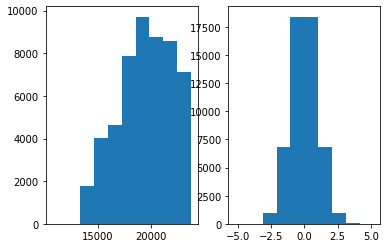

In [26]:
dq =qt.fit_transform(X_train['age'].values.reshape(-1,1))
plt.subplot(1,2,1)
plt.hist(X_train['age'])
plt.tick_params(axis='both', which='major', labelsize=10)
plt.subplot(1,2,2)
plt.hist(dq)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()

In [27]:
X_train['age_QuantileTransformer'] = dq
X_train['age_year_bins'] = d
X_train.head(3)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,age_year,age_year_bins,age_QuantileTransformer
4497,15212,2,170,85.0,130,80,3,3,1,0,1,41,41,-1.545927
8301,15361,1,165,70.0,110,70,1,1,0,0,1,42,42,-1.411293
63679,19822,1,174,72.0,120,80,1,1,0,0,0,54,54,0.076416


Weight

In [28]:
X_train['weight'].quantile([0.25, 0.5, 0.75, 1])

0.25     65.0
0.50     72.0
0.75     82.0
1.00    200.0
Name: weight, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


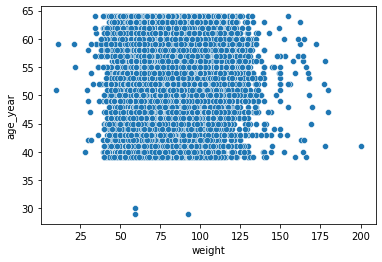

In [29]:
## Посмотрим выбросы по признаку weight в соотношении с признаком age_year
sns.scatterplot(X_train['weight'], X_train['age_year'] )


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


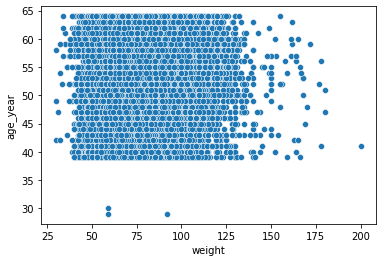

In [30]:
##заменим значения веса меньше 30 кг на медиану
X_train.loc[X_train['weight'] <30, 'weight'] = X_train['weight'].median()
sns.scatterplot(X_train['weight'], X_train['age_year'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


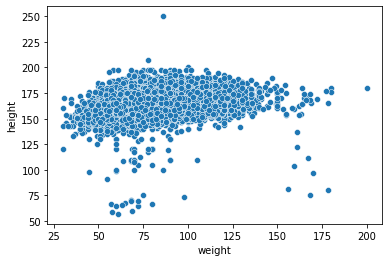

In [31]:
## Посмотрим выбросы по признаку weight в соотношении с признаком height
sns.scatterplot(X_train['weight'], X_train['height'])

In [32]:
## посмотрим наблюдения, где рост меньшей 100 см
a = X_train.loc[X_train['height'] < 100]
a.shape

(21, 14)

In [33]:
##отнесем к выбросам значения weight больше 100 кг для пациентов с ростом меньше 1 м и возрастом больше 40 лет.
## Удалим эти наблюдения
X_train = X_train.drop(a.index)
y_train = y_train.drop(a.index)

In [34]:
## также уберем сразу наблюдение с height 250 см
h = X_train.loc[X_train['height'] > 240]
X_train = X_train.drop(h.index)
y_train = y_train.drop(h.index)

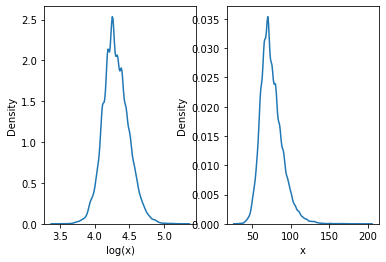

In [35]:
## добавим признак weight_log, вычисляется как np.log(X_train['weight']
plt.subplot(1,2,1)
sns.kdeplot(np.log(X_train['weight'].values+1))
plt.xlabel('log(x)')
plt.subplot(1,2,2)
sns.kdeplot((X_train['weight'].values+1))
plt.xlabel('x')
plt.show()

In [36]:
X_train['weight_log'] = np.log(X_train['weight'])

ap_hi, ap_ho

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


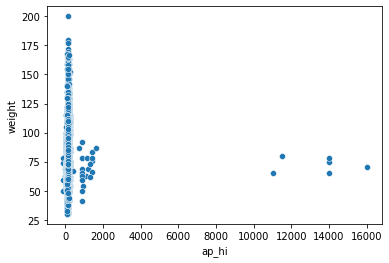

In [37]:
## Посмотрим выбросы по признаку weight в соотношении с признаком height
sns.scatterplot(X_train['ap_hi'], X_train['weight'])

In [38]:
## посмотрим наблюдения, где ap_hi меньше 0 и заменим отрицательные значения на модуль.
a = X_train.loc[X_train['ap_hi'] <= 0]
a

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,age_year,age_year_bins,age_QuantileTransformer,weight_log
23988,18301,1,162,74.0,-140,90,1,1,0,0,1,50,50,-0.478025,4.304065
35040,23325,2,168,59.0,-150,80,1,1,0,0,1,63,63,1.778266,4.077537
25240,14711,2,168,50.0,-120,80,2,1,0,0,0,40,40,-1.769902,3.912023
4607,15281,1,165,78.0,-100,80,2,1,0,0,1,41,41,-1.481966,4.356709


In [39]:
X_train.loc[X_train['ap_hi'] <=0, 'ap_hi'] = X_train['ap_hi'].abs()

In [40]:
##отнесем к выбросам значения ap_lo <= 0. Удалим эти значения из обучающей выборки
## Удалим эти наблюдения
X_train = X_train.drop(a.index)
y_train = y_train.drop(a.index)

In [41]:
X_train.shape, y_train.shape

((52474, 15), (52474, 1))

In [42]:
## Теперь применим все изменения X_train к X_test
d = np.floor_divide( X_test['age'], 365)
X_test['age_year'] = d
d2= pd.qcut(X_test['age_year'], 4, labels=False)
X_test['age_year_bins'] = d2
dq1 =qt.fit_transform(X_test['age'].values.reshape(-1,1))
X_test['age_QuantileTransformer'] = dq1
##заменим значения веса меньше 30 кг на медиану
X_test.loc[X_test['weight'] <30, 'weight'] = X_test['weight'].median()
## посмотрим наблюдения, где рост меньшей 100 см
a = X_test.loc[X_test['height'] < 100]
X_test = X_test.drop(a.index)
y_test = y_test.drop(a.index)
## посмотрим наблюдения, где ap_hi меньше 0 и заменим отрицательные значения на модуль.
X_test.loc[X_test['ap_hi'] <=0, 'ap_hi'] = X_test['ap_hi'].abs()
## удалим наблюдения, где ap_lo = 0.
a = X_test.loc[X_test['ap_lo'] <= 0]
X_test = X_test.drop(a.index)
y_test = y_test.drop(a.index)

In [43]:
## также уберем сразу наблюдение с height 250 см
h = X_test.loc[X_test['height'] > 240]
X_test = X_test.drop(h.index)
y_test = y_test.drop(h.index)

In [44]:
## добавим признак weight_log, вычисляется как np.log(X_test['weight']
X_test['weight_log'] = np.log(X_test['weight'])

In [45]:
X_test.shape, y_test.shape

((17487, 15), (17487, 1))

К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active и вновь созданные признаки- оставим пока как есть

In [46]:
X_train.columns

Index(['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol',
       'gluc', 'smoke', 'alco', 'active', 'age_year', 'age_year_bins',
       'age_QuantileTransformer', 'weight_log'],
      dtype='object')

In [47]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler

## уберем признаки 'age' и 'weight'
continuos_cols = [##'age',
                  'height',
                  ##'weight',
                  'ap_hi',
                  'ap_lo'
                  ]
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc',
             'smoke',
             'alco',
             'active',
             'age_year',
             'age_year_bins',
             'age_QuantileTransformer',
             'weight_log'
             ]

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [48]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[ 7.01275155e-01,  8.37203154e-03, -9.11992291e-02, ...,
         4.10000000e+01, -1.54592732e+00,  4.44265126e+00],
       [ 7.53423893e-02, -1.28665208e-01, -1.44565084e-01, ...,
         4.20000000e+01, -1.41129327e+00,  4.24849524e+00],
       [ 1.20202137e+00, -6.01465883e-02, -9.11992291e-02, ...,
         5.40000000e+01,  7.64158860e-02,  4.27666612e+00],
       ...,
       [ 1.20202137e+00, -6.01465883e-02, -9.11992291e-02, ...,
         6.10000000e+01,  1.08370672e+00,  4.27666612e+00],
       [-1.42689625e+00, -6.01465883e-02, -9.11992291e-02, ...,
         5.00000000e+01, -4.65125142e-01,  4.44265126e+00],
       [ 5.76088602e-01,  1.45409271e-01, -3.78333745e-02, ...,
         5.50000000e+01,  2.61387373e-01,  4.29045944e+00]])

Добавим классификатор и запустим кросс-валидацию

In [49]:
res = []
models = ['LogisticRegression','RandomForestClassifier', 'GradientBoostingClassifier', 'XGBClassifier', 'CatBoostClassifier']
for model in models:
    item = {
          'model': model,
          'preds' : None,
          'cv_score': None,
          'cv_score_std': None,
          'thresholds': None,
          'precision': None,
          'recall': None,
          'fscore': None,
          'roc_auc_score': None,
          'logloss': None,
          'TN': None,
          'FN': None,
          'TP': None,
          'FP': None,
          'TPR': None,
          'FPR': None,
          'TNR':None
          }
    res.append(item)

In [50]:
## LogisticRegression(random_state = 42, C = 1, solver = 'liblinear')
classifier = Pipeline([
('features',feats),
('classifier', LogisticRegression(random_state = 42, C = 1, solver = 'liblinear'))])
#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train.iloc[:,-1:].values.ravel(), cv=10, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))    

CV score is 0.7876234580694371+-0.006255438525980576


In [51]:
#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train.iloc[:,-1:].values.ravel())
y_score = classifier.predict_proba(X_test)[:, 1]

In [52]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                            fscore[ix],
                                                                            precision[ix],
                                                                            recall[ix]))

Best Threshold=0.414918, F-Score=0.731, Precision=0.677, Recall=0.795


In [53]:
roc_auc = roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])
logloss= log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])))

roc auc score: 0.7855624305865332
log loss score: 0.574845549542201


In [54]:
for item in res:
    if ('LogisticRegression') in item['model']:
        item['cv_score_std'] = cv_score_std
        item['cv_score'] = cv_score
        item['preds'] = y_score
        item['thresholds'] = thresholds[ix]
        item['precision'] = precision[ix]
        item['recall'] = recall[ix]
        item['fscore'] = fscore[ix]
        item['roc_auc_score'] = roc_auc
        item['logloss']= logloss   

In [55]:
## RandomForestClassifier(n_estimators = 100, min_samples_split=2, min_samples_leaf=1, max_depth=None)
classifier = Pipeline([
('features',feats),
('classifier',  RandomForestClassifier(n_estimators = 100, min_samples_split=100, min_samples_leaf=50, max_depth=20))])
#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train.iloc[:,-1:].values.ravel(), cv=10, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

CV score is 0.8009909221856208+-0.005912067229705476


In [56]:
#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train.iloc[:,-1:].values.ravel())
y_score = classifier.predict_proba(X_test)[:, 1]

In [57]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                            fscore[ix],
                                                                            precision[ix],
                                                                            recall[ix])) 

Best Threshold=0.339880, F-Score=0.740, Precision=0.683, Recall=0.807


In [59]:
roc_auc = roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])
logloss= log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])))

roc auc score: 0.7998898018290489
log loss score: 0.5448293995468073


In [60]:
for item in res:
    if ('RandomForestClassifier') in item['model']:
        item['cv_score_std'] = cv_score_std
        item['cv_score'] = cv_score
        item['preds'] = y_score
        item['thresholds'] = thresholds[ix]
        item['precision'] = precision[ix]
        item['recall'] = recall[ix]
        item['fscore'] = fscore[ix]
        item['roc_auc_score'] = roc_auc
        item['logloss']= logloss  

In [61]:
## GradientBoostingClassifier(random_state = 42)
classifier = Pipeline([
('features',feats),
('classifier',  GradientBoostingClassifier(random_state = 42))])
#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train.iloc[:,-1:].values.ravel(), cv=10, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

CV score is 0.80235796347171+-0.0060344253765942345


In [66]:
classifier.fit(X_train, y_train.iloc[:,-1:].values.ravel())
y_score = classifier.predict_proba(X_test)[:, 1]

In [67]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                            fscore[ix],
                                                                            precision[ix],
                                                                            recall[ix]))                                                            

Best Threshold=0.389135, F-Score=0.741, Precision=0.693, Recall=0.796


In [68]:
roc_auc = roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])
logloss= log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])))

roc auc score: 0.802306652835209
log loss score: 0.5400322718154053


In [69]:
for item in res:
    if ('GradientBoostingClassifier') in item['model']:
        item['cv_score_std'] = cv_score_std
        item['cv_score'] = cv_score
        item['preds'] = y_score
        item['thresholds'] = thresholds[ix]
        item['precision'] = precision[ix]
        item['recall'] = recall[ix]
        item['fscore'] = fscore[ix]
        item['roc_auc_score'] = roc_auc
        item['logloss']= logloss                                                             

In [75]:
##XGBClassifier
classifier = Pipeline([
    ('features',feats),
    ('classifier', XGBClassifier(random_state = 42))
])
cv_scores = cross_val_score(classifier, X_train, y_train.iloc[:,-1:].values.ravel(), cv=10, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

CV score is 0.8024960532295162+-0.005870360603122305


In [76]:
classifier.fit(X_train, y_train.iloc[:,-1:].values.ravel())
y_score = classifier.predict_proba(X_test)[:, 1]

In [77]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.928368, F-Score=nan, Precision=0.000, Recall=0.000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [78]:
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])))

roc auc score: 0.8024048356903933
log loss score: 0.5400234249760729


In [79]:
for item in res:
    if ('XGBClassifier') in item['model']:
        item['cv_score_std'] = cv_score_std
        item['cv_score'] = cv_score
        item['preds'] = y_score
        item['thresholds'] = thresholds[ix]
        item['precision'] = precision[ix]
        item['recall'] = recall[ix]
        item['fscore'] = fscore[ix]
        item['roc_auc_score'] = roc_auc
        item['logloss']= logloss 

In [80]:
## CatBoostClassifier
classifier = Pipeline([
    ('features',feats),
    ('classifier', CatBoostClassifier(random_state = 42, iterations= 40))
])
cv_scores = cross_val_score(classifier, X_train, y_train.iloc[:,-1:].values.ravel(), cv=10, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

Learning rate set to 0.5
0:	learn: 0.5961419	total: 11.3ms	remaining: 440ms
1:	learn: 0.5646924	total: 21.5ms	remaining: 409ms
2:	learn: 0.5520468	total: 31.9ms	remaining: 393ms
3:	learn: 0.5465899	total: 43.2ms	remaining: 389ms
4:	learn: 0.5431756	total: 53.7ms	remaining: 376ms
5:	learn: 0.5418632	total: 63.3ms	remaining: 359ms
6:	learn: 0.5403648	total: 73.2ms	remaining: 345ms
7:	learn: 0.5394745	total: 82.7ms	remaining: 331ms
8:	learn: 0.5385560	total: 92.4ms	remaining: 318ms
9:	learn: 0.5377700	total: 103ms	remaining: 309ms
10:	learn: 0.5373522	total: 112ms	remaining: 297ms
11:	learn: 0.5368436	total: 122ms	remaining: 285ms
12:	learn: 0.5367008	total: 132ms	remaining: 274ms
13:	learn: 0.5365123	total: 141ms	remaining: 262ms
14:	learn: 0.5360656	total: 151ms	remaining: 252ms
15:	learn: 0.5354382	total: 161ms	remaining: 241ms
16:	learn: 0.5350186	total: 171ms	remaining: 232ms
17:	learn: 0.5343483	total: 181ms	remaining: 221ms
18:	learn: 0.5335915	total: 191ms	remaining: 211ms
19:	lea

In [81]:
classifier.fit(X_train, y_train.iloc[:,-1:].values.ravel())
y_score = classifier.predict_proba(X_test)[:, 1]

Learning rate set to 0.5
0:	learn: 0.5958199	total: 12.3ms	remaining: 481ms
1:	learn: 0.5643756	total: 23.4ms	remaining: 445ms
2:	learn: 0.5523537	total: 34.4ms	remaining: 424ms
3:	learn: 0.5465465	total: 45.7ms	remaining: 411ms
4:	learn: 0.5432948	total: 56.8ms	remaining: 397ms
5:	learn: 0.5415820	total: 67.1ms	remaining: 380ms
6:	learn: 0.5402823	total: 77.4ms	remaining: 365ms
7:	learn: 0.5395557	total: 87.8ms	remaining: 351ms
8:	learn: 0.5386435	total: 98.7ms	remaining: 340ms
9:	learn: 0.5381013	total: 109ms	remaining: 327ms
10:	learn: 0.5376210	total: 125ms	remaining: 331ms
11:	learn: 0.5373180	total: 136ms	remaining: 317ms
12:	learn: 0.5368761	total: 147ms	remaining: 305ms
13:	learn: 0.5366260	total: 157ms	remaining: 292ms
14:	learn: 0.5363932	total: 168ms	remaining: 280ms
15:	learn: 0.5357074	total: 178ms	remaining: 268ms
16:	learn: 0.5354362	total: 189ms	remaining: 256ms
17:	learn: 0.5350102	total: 202ms	remaining: 247ms
18:	learn: 0.5345471	total: 214ms	remaining: 236ms
19:	lea

In [82]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.278956, F-Score=0.740, Precision=0.668, Recall=0.828


In [83]:
print("roc auc score: {}".format(roc_auc_score(y_true=1-y_test, y_score=classifier.predict_proba(X_test)[:,0])))
print("log loss score: {}".format(log_loss(y_true=1-y_test, y_pred=classifier.predict_proba(X_test)[:,0])))

roc auc score: 0.8010255336906315
log loss score: 0.55103131083831


In [106]:
for item in res:
    if ('CatBoostClassifier') in item['model']:
        item['cv_score_std'] = cv_score_std
        item['cv_score'] = cv_score
        item['preds'] = y_score
        item['thresholds'] = thresholds[ix]
        item['precision'] = precision[ix]
        item['recall'] = recall[ix]
        item['fscore'] = fscore[ix]
        item['roc_auc_score'] = roc_auc
        item['logloss']= logloss
        item['y_score'] = classifier.predict_proba(X_test)[:,0]

Нарисуем roc auc кривую (кстати, наверное неплохо бы ее вынести в отдельную функцию)

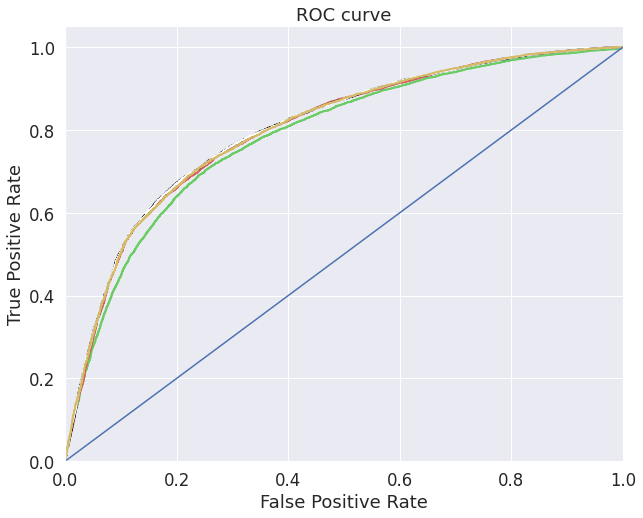

In [85]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, res[0]['preds'], pos_label=1)
fpr1, tpr1, thresholds_1 = roc_curve(y_test, res[1]['preds'], pos_label=1)
fpr2, tpr2, thresholds_2 = roc_curve(y_test, res[2]['preds'], pos_label=1)
fpr3, tpr3, thresholds_3 = roc_curve(y_test, res[3]['preds'], pos_label=1)
fpr4, tpr4, thresholds_4 = roc_curve(y_test, res[4]['preds'], pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, color = 'g', label='ROC curve ')
plt.plot(fpr1, tpr1, lw=lw, color = 'r')
plt.plot(fpr2, tpr2, lw=lw, color = 'k')
plt.plot(fpr3, tpr3, lw=lw, color = 'w')
plt.plot(fpr4, tpr4, lw=lw, color = 'y')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [86]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [87]:
def metrics(cnf_matrix):
    TN = cnf_matrix[0][0]
    FN = cnf_matrix[1][0]
    TP = cnf_matrix[1][1]
    FP = cnf_matrix[0][1]

    TPR = TP/(TP+FN)
    FPR = FP/(FP+TN)
    TNR = TN/(FP+TN)
    return TP, TN, FP, FN, TPR, FPR, TNR

In [88]:
## 
def get_confused_matrix(i):
    font = {'size' : 10}

    plt.rc('font', **font)

    business_threshold = 1  # подберем порог для улучшения бизнесс показателя

    cnf_matrix = confusion_matrix(y_test, res[i]['preds']>res[i]['thresholds']*business_threshold)
    plt.figure(figsize=(10, 8))
    plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix_{}'.format(res[i]['model']))
    plt.savefig("conf_matrix.png")
    plt.show()
    return cnf_matrix

Посмoтрим на матрицу ошибок

Confusion matrix, without normalization
[[5525 3287]
 [1783 6892]]


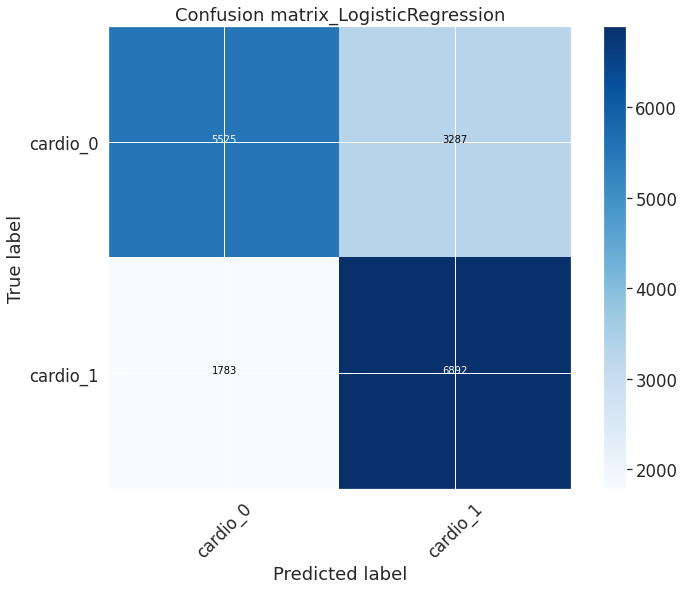

In [89]:
## LogisticRegression
for item in res:
    if ('LogisticRegression') in item['model']:
        item['TP'], item['TN'], item['FP'], item['FN'], item['TPR'], item['FPR'], item['TNR'] = metrics(get_confused_matrix(0))


Confusion matrix, without normalization
[[5562 3250]
 [1676 6999]]


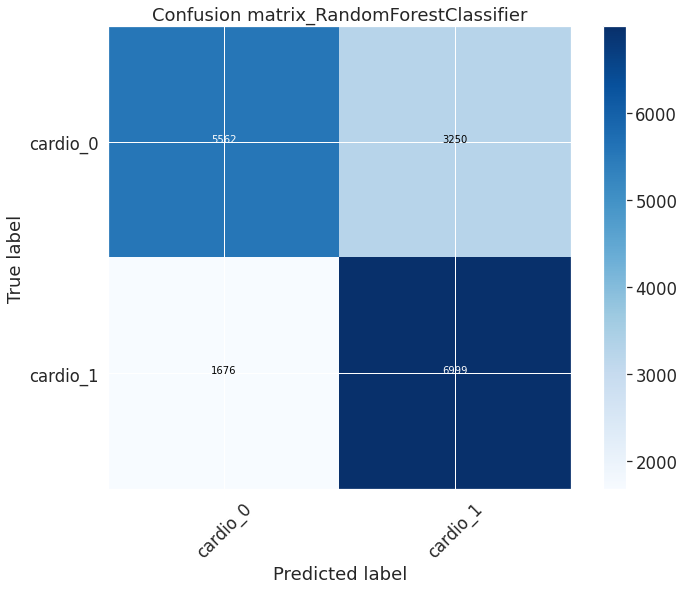

In [90]:
## RandomForestClassifier
for item in res:
    if ('RandomForestClassifier') in item['model']:
        item['TP'], item['TN'], item['FP'], item['FN'], item['TPR'], item['FPR'], item['TNR'] = metrics(get_confused_matrix(1))

Confusion matrix, without normalization
[[5751 3061]
 [1775 6900]]


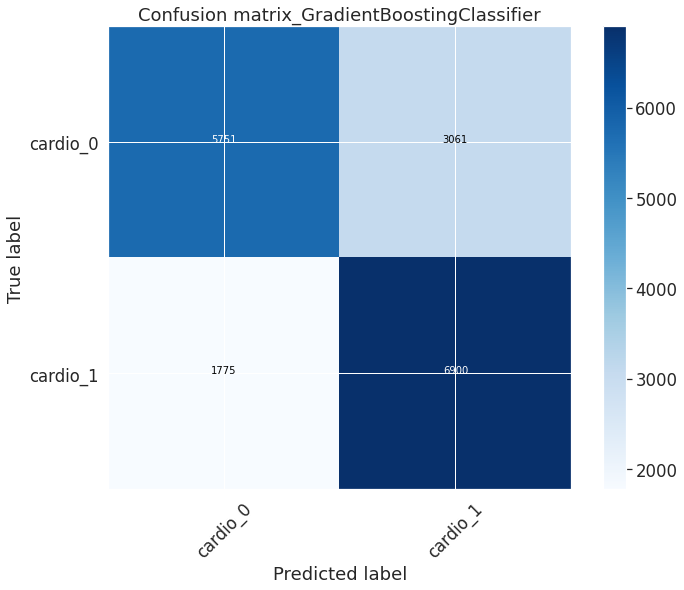

In [91]:
## 'GradientBoostingClassifier'
for item in res:
    if ('GradientBoostingClassifier') in item['model']:
        item['TP'], item['TN'], item['FP'], item['FN'], item['TPR'], item['FPR'], item['TNR'] = metrics(get_confused_matrix(2))

Confusion matrix, without normalization
[[8812    0]
 [8675    0]]


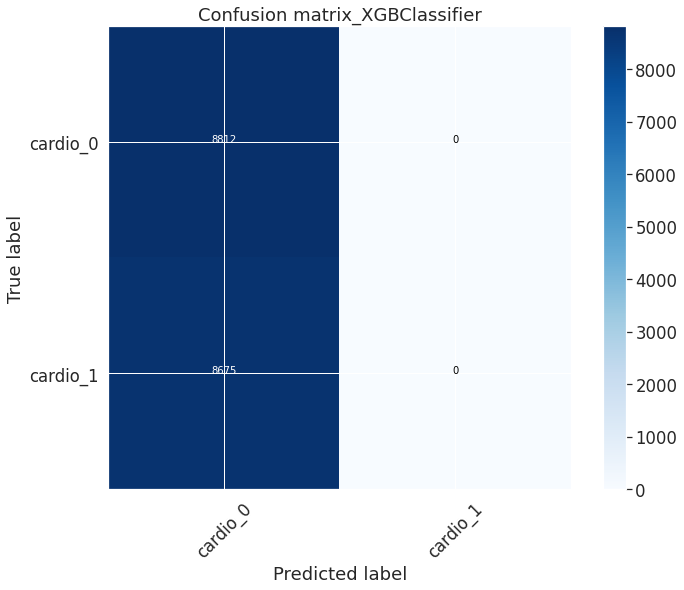

In [92]:
## ''XGBClassifier''
for item in res:
    if ('XGBClassifier') in item['model']:
        item['TP'], item['TN'], item['FP'], item['FN'], item['TPR'], item['FPR'], item['TNR'] = metrics(get_confused_matrix(3))

Confusion matrix, without normalization
[[5249 3563]
 [1490 7185]]


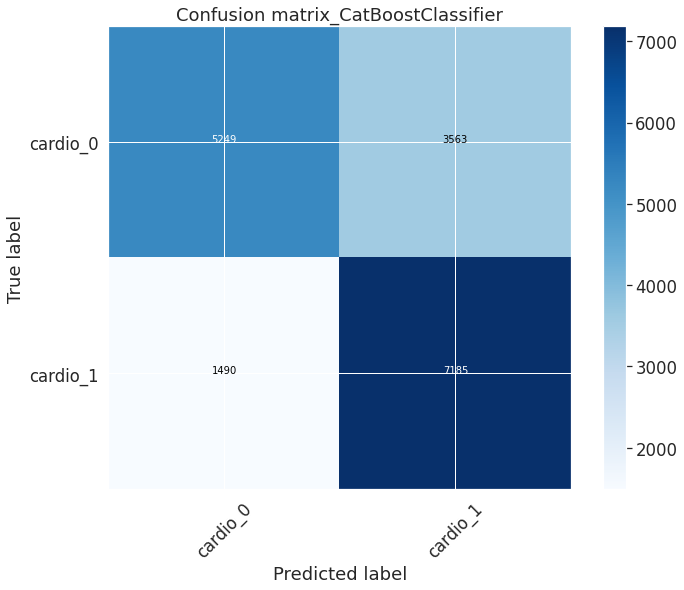

In [93]:
## 'CatBoostClassifier'
for item in res:
    if ('CatBoostClassifier') in item['model']:
        item['TP'], item['TN'], item['FP'], item['FN'], item['TPR'], item['FPR'], item['TNR'] = metrics(get_confused_matrix(4))

In [ ]:
## Соберем данные в единую таблицу

In [94]:
data = []

for item in res:
     data.append([item['model'],
                  item['precision'],
                  item['recall'],
                  item['fscore'],
                  item['roc_auc_score'],
                  item['cv_score'],
                  item['TP'],
                  item['FN'],
                  item['TN'],
                  item['FP'],
                  item['TPR'],
                  item['FPR'],
                  item['TNR'],
                  item['logloss']
                  ])

summary = pd.DataFrame(data, columns = ['model', 'precision', 'recall', 'fscore', 'roc_auc_score', 'cv_score', 'TP','FN',
                                        'TN', 'FP', 'TPR', 'FPR', 'TNR', 'logloss']
                       )
summary.sort_values(by='roc_auc_score')
summary

,model,precision,recall,fscore,roc_auc_score,cv_score,TP,FN,TN,FP,TPR,FPR,TNR,logloss
0,LogisticRegression,0.677112,0.794582,0.731159,0.785562,0.787623,6892,1783,5525,3287,0.794467,0.373014,0.626986,0.574846
1,RandomForestClassifier,0.682927,0.806916,0.739762,0.799890,0.800991,6999,1676,5562,3250,0.806801,0.368815,0.631185,0.544829
2,GradientBoostingClassifier,0.692516,0.795735,0.740546,0.802307,0.802358,6900,1775,5751,3061,0.795389,0.347367,0.652633,0.540032
3,XGBClassifier,0.000000,0.000000,NaN,0.802307,0.802496,0,8675,8812,0,0.000000,0.000000,1.000000,0.540032
4,CatBoostClassifier,0.668465,0.828357,0.739871,0.802307,0.801755,7185,1490,5249,3563,0.828242,0.404335,0.595665,0.540032


Самый высокий roc_auc_score у моделей GradietnBoostingClassifier, XGBClassifier и CatBoostClassifier. 




#### Пусть:
 - стоимость лечения 15000 р, если сделали тест и начали лечить вовремя
 - стоимость лечения 20000, если упустили и начали лечить когда уже проявились все симптомы 
 - стоимость теста 1400 р
 
 
 
 - лишних тестов сделали FP = cnf_matrix[0][1] = res[i][FN]
 - пропустили больных FN = cnf_matrix[1][0] = res[i][FN]
 - правильных тестов сделали TP = cnf_matrix[1][1] = res[i][TP]

Оценим расходы, если не делать тест и ждать симптомов:

In [98]:
## посмотрим результаты расчетов расходов по каждому из алгоритмов:
rubl_to_test = 1400
rubl_to_early_treatment = 15000
rubl_to_late_treatment = 20000


models = []
for item in res:
    rubl_1 = (item['FN']+item['TP']) * rubl_to_late_treatment
    rubl_all_test = np.sum([item['FP'], item['TP'], item['TN'], item['FN']]) * rubl_to_test + (item['FN']+item['TP']) * rubl_to_early_treatment
    rubl_ML = (item['FP']+item['TP']) * rubl_to_test + item['FN'] * rubl_to_late_treatment + np.sum(item['TP']) * rubl_to_early_treatment
    model = {}
    model['model'] = item['model']
    model['не тестировать'] = rubl_1
    model['тестировать всех'] = rubl_all_test
    model['ML'] = rubl_ML
    models.append(model)

In [100]:
summary_business = pd.DataFrame(models, columns = ['model', 'не тестировать', 'тестировать всех', 'ML'])
summary_business.sort_values(by='ML')                             

,model,не тестировать,тестировать всех,ML
4,CatBoostClassifier,173500000,154606800,152622200
1,RandomForestClassifier,173500000,154606800,152853600
2,GradientBoostingClassifier,173500000,154606800,152945400
0,LogisticRegression,173500000,154606800,153290600
3,XGBClassifier,173500000,154606800,173500000


Получается, что лучше всего для предсказания сточки зрения бизнеса работает модель CatBoostClassifier

Оценим разницу:


In [101]:
print(' Расходы при решении не делать тесты - расходы с МL :',rubl_1 - rubl_ML )
print(' Расходы при решении не делать тесты - расходы ссделать тесты всем  :',rubl_1 - rubl_all_test )
print(' Расходы сделать тесты всем - решение делать тесты ML  :',rubl_all_test - rubl_ML )

 Расходы при решении не делать тесты - расходы с МL : 20877800
 Расходы при решении не делать тесты - расходы ссделать тесты всем  : 18893200
 Расходы сделать тесты всем - решение делать тесты ML  : 1984600


Метрика по деньгам : получить меньше расходов чем при полном тесте

Расходы на тестирование всех и лечение при ранней диагностике - расходы на ML тест и лечение при ранней диагностике группы TP и поздней диагностике группы FN

In [117]:
def business_threshold_calibrate(y_test, y_score, thresholds,rubl_to_test = 100, rubl_to_early_treatment = 100, rubl_to_late_treatment = 1000):
    business_threshold = 0
    r1_r2_ = 0
    r1_r3_ = 0
    r2_r3_ = 0
    rubl_1_ = - 10000000 
    rubl_all_test_ = - 10000000 
    rubl_ML_ = - 10000000 

    r2 = []
    n = 20
    for opt_buisness_tr in np.linspace(0,1,n).tolist():
        # подберем порог для улучшения бизнесс показателя

        cnf_matrix = confusion_matrix(y_test, y_score > ( opt_buisness_tr))
        #print(cnf_matrix )
        rubl_1 = (item['FN']+item['TP']) * rubl_to_late_treatment
        rubl_all_test = np.sum([item['FP'], item['TP'], item['TN'], item['FN']]) * rubl_to_test + (item['FN']+item['TP']) * rubl_to_early_treatment
        rubl_ML = (item['FP']+item['TP']) * rubl_to_test + item['FN'] * rubl_to_late_treatment + np.sum(item['TP']) * rubl_to_early_treatment
        r2_r3 = rubl_all_test - rubl_ML        
        r1_r2 = rubl_1 - rubl_all_test
        r1_r3 = rubl_1 - rubl_ML
        print(opt_buisness_tr, r2_r3)
        if (r2_r3_ > r1_r3):
            
            business_threshold = opt_buisness_tr
            r1_r2_ = r1_r2
            r1_r3_ = r1_r3
            r2_r3_ = r2_r3
            rubl_1_ = rubl_1
            rubl_all_test_ = rubl_all_test
            rubl_ML_ = rubl_ML
            
        r2.append(r2_r3)   
            
    
    print('расходы, если не делать тест и ждать симптомов:',rubl_1_)
    print('расходы, если делать тест всем и лечить группу большых:',rubl_all_test_)
    print('расходы, если не делать тест и ждать симптомов:',rubl_ML_)
    print(' Расходы при решении не делать тесты - расходы с МL :',r1_r3_ )
    print(' Расходы при решении не делать тесты - расходы ссделать тесты всем  :',r1_r2_ )
    print(' Расходы сделать тесты всем - решение делать тесты ML  :',r2_r3_ )
    plt.plot(np.linspace(0,1,n),r2)
    plt.show()
    return business_threshold, r2
    

0.0 1984600
0.05263157894736842 1984600
0.10526315789473684 1984600
0.15789473684210525 1984600
0.21052631578947367 1984600
0.2631578947368421 1984600
0.3157894736842105 1984600
0.3684210526315789 1984600
0.42105263157894735 1984600
0.47368421052631576 1984600
0.5263157894736842 1984600
0.5789473684210527 1984600
0.631578947368421 1984600
0.6842105263157894 1984600
0.7368421052631579 1984600
0.7894736842105263 1984600
0.8421052631578947 1984600
0.894736842105263 1984600
0.9473684210526315 1984600
1.0 1984600
расходы, если не делать тест и ждать симптомов: -10000000
расходы, если делать тест всем и лечить группу большых: -10000000
расходы, если не делать тест и ждать симптомов: -10000000
 Расходы при решении не делать тесты - расходы с МL : 0
 Расходы при решении не делать тесты - расходы ссделать тесты всем  : 0
 Расходы сделать тесты всем - решение делать тесты ML  : 0


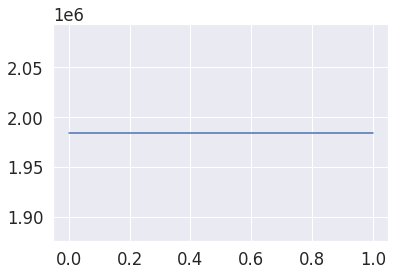

уровень порога по бизнес метрике (0, [1984600, 1984600, 1984600, 1984600, 1984600, 1984600, 1984600, 1984600, 1984600, 1984600, 1984600, 1984600, 1984600, 1984600, 1984600, 1984600, 1984600, 1984600, 1984600, 1984600])
уровень порога по f1 метрике 0.27895643007891696


In [118]:
BUisnes_tr = business_threshold_calibrate(y_test, res[4]['y_score'], 
                                          res[4]['thresholds'],
                                          rubl_to_test = 1400, 
                                          rubl_to_early_treatment = 15000, 
                                          rubl_to_late_treatment = 20000)
print('уровень порога по бизнес метрике',BUisnes_tr)
print('уровень порога по f1 метрике',res[4]['thresholds'])

### Домашнее задание

1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. при обучении моделей обязательно использовать кроссвалидацию
3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
4. сделать выводы о том, какая модель справилась с задачей лучше других
5. (опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого). 

p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно). 
Допустим, у нас две модели:

- первая помечает 100 объектов как класс 1, но TP = 90
- вторая помечает 1000 объектов как класс 1, но TP такой же - 90

Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

### Ссылки

1. https://dyakonov.org/2017/07/28/auc-roc-площадь-под-кривой-ошибок/
2. https://en.wikipedia.org/wiki/Receiver_operating_characteristic